In [2]:
from pyvis import network as pvnet
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
from networkx.drawing.nx_pydot import write_dot

In [3]:
%config Completer.use_jedi = False

In [4]:
# Visualizing a graph using pyvis
def plot_graph_with_pyviz(G, name='out.html', height='500px', width='600px'):
    G_copy = G.copy() # some attributes added to nodes
    net = pvnet.Network(notebook=True, directed=True, height=height, width=width)
    opts = '''
        var options = {
          "physics": {
            "forceAtlas2Based": {
              "gravitationalConstant": -100,
              "centralGravity": 0.11,
              "springLength": 100,
              "springConstant": 0.09,
              "avoidOverlap": 1
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based",
            "timestep": 0.22
          }
        }
    '''

    net.set_options(opts)
    net.from_nx(G_copy)
    return net.show(name)

## P9.1

Find the analytical formula of the ergodic density for random
walk on a graph given by adjacency matrix $A$ with Markov
operator $p_{ji} = \dfrac{A_{ij}}{k_i}.$

Let $P = [p_{ij}]_{i\in S, j\in S}$ represent a Markov process and $k$ represent the degrees of nodes. Recall that $p_{ji} = \dfrac{A_{ij}}{k_i}.$ Let us multiply $P$ by $k.$

$$ [Pk]_m = \sum_n p_{mn} k_n = \sum_n \dfrac{A_{nm}}{k_n}\cdot k_n = \sum_n A_{nm} = k_m$$

This means that $Pk = k$ and scaled $k$ is a stationary distribution. 

$$ \tilde{k} = \dfrac{k}{\sum_n k_n}$$

If the number of nodes is finite and the graph is non-periodic and irreducible, then $\tilde{k}$ is ergodic distribution of this process. Therefore, it doesn't always exist.

## P9.2

Determine numerically (looking for the eigenvector) values of
ergodic density for the random walk on selected network. [1P]

In [5]:
def random_stochastic_matrix(N: int, seed: int = None) -> np.array:
    np.random.seed(seed)
    
    # random values
    M = np.random.rand(N, N)
    
    # random zeros
    for _ in range(np.random.randint(0, N*N)):
        M[np.random.randint(0, N), np.random.randint(0, N)] = 0
    
    # making a matrix stochastic
    M = M / M.sum(axis=0)
    np.random.seed() #reset
    
    return M

In [6]:
M = random_stochastic_matrix(10, seed=10)
M.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  ],
       [0.52, 0.  , 0.  , 0.21, 0.  , 0.  , 0.  , 0.  , 0.51, 0.39],
       [0.  , 0.06, 0.  , 0.  , 0.36, 0.23, 0.28, 0.21, 0.  , 0.33],
       [0.  , 0.21, 0.46, 0.13, 0.  , 0.  , 0.  , 0.34, 0.  , 0.  ],
       [0.  , 0.33, 0.1 , 0.35, 0.29, 0.  , 0.  , 0.36, 0.18, 0.  ],
       [0.  , 0.04, 0.  , 0.06, 0.32, 0.49, 0.45, 0.  , 0.  , 0.  ],
       [0.45, 0.36, 0.27, 0.  , 0.03, 0.  , 0.04, 0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.16, 0.26, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.1 , 0.31, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.  , 0.  , 0.28]])

In [7]:
def generate_Markov(M, eps=1e-5):
    n = M.shape[0]
    G = nx.MultiDiGraph()
    
    for i in range(n):
        G.add_node(i)

    for row in range(n):
        for col in range(n):
            rate = M[row, col]
            if rate > eps:
                G.add_edge(col, row, weight=rate, label=np.round(rate, 2))
    return G.copy()

In [8]:
G_markov = generate_Markov(M)
plot_graph_with_pyviz(G_markov)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [9]:
eigenvalues, eigenvectors = scipy.linalg.eig(M)
eigenvalues

array([ 1.        +0.j        ,  0.38849165+0.j        ,
        0.26998964+0.29413655j,  0.26998964-0.29413655j,
        0.07358284+0.2524643j ,  0.07358284-0.2524643j ,
       -0.30025845+0.j        , -0.1737145 +0.08102735j,
       -0.1737145 -0.08102735j,  0.11192549+0.j        ])

In [10]:
rounded_eigenvectors = np.round(np.real(eigenvectors), 2)
pi = rounded_eigenvectors[:, np.where(np.abs(eigenvalues - 1)<1e-14),].flatten()
pi /= pi.sum()
np.round(pi, 3)

array([0.007, 0.074, 0.171, 0.134, 0.164, 0.201, 0.086, 0.067, 0.026,
       0.071])

## P9.3

Determine dynamically (by iterating the Markov operator)
ergodic density for the random walk on selected network. [1P]

In [12]:
M_for_iteration = M.copy()
for _ in range(30):
    M_for_iteration = np.matmul(M_for_iteration, M_for_iteration)

In [13]:
M_for_iteration.round(2)

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07],
       [0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17],
       [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13],
       [0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16],
       [0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 , 0.2 ],
       [0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],
       [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]])

In [14]:
G_markov = generate_Markov(M_for_iteration)
plot_graph_with_pyviz(G_markov)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## P9.5

Determine the value of classic or modified pagerank for the
selected network. [1.5P]


In [15]:
N = 30
M = 50
G = nx.generators.barabasi_albert_graph(M, N)

In [16]:
G2 = nx.DiGraph(nx.directed.random_k_out_graph(15, 5, 0.7, seed=12))
plot_graph_with_pyviz(G)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [17]:
A = nx.linalg.adjacency_matrix(G).todense()
A_normalized = (A / A.sum(axis=1)).round(2)
A_normalized

/tmp/ipykernel_528/693543473.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.linalg.adjacency_matrix(G).todense()


array([[0.  , 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.08, 0.  , 0.  , ..., 0.08, 0.  , 0.  ],
       [0.06, 0.  , 0.  , ..., 0.06, 0.  , 0.06],
       ...,
       [0.03, 0.03, 0.03, ..., 0.  , 0.03, 0.03],
       [0.03, 0.  , 0.  , ..., 0.03, 0.  , 0.03],
       [0.03, 0.  , 0.03, ..., 0.03, 0.03, 0.  ]])

In [18]:
A2 = nx.linalg.adjacency_matrix(G2).todense()
A2_normalized = (A2 / A2.sum(axis=1)).round(2)
A2_normalized

/tmp/ipykernel_528/2355979357.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.adjacency_matrix(G2).todense()


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.2 , 0.2 , 0.2 , 0.  ,
        0.  , 0.2 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.33, 0.  , 0.  , 0.33, 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.25, 0.  ,
        0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.  ,
        0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.33, 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.33, 0.  ,
        0.  , 0.33, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.33, 0.  ,
        0.  , 0.33, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.2 , 0.  , 0.2 , 0.  , 0.  ,
        0.  , 0.2 , 0.  , 0.2 ],
       [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.  ,
        0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ,

In [19]:
G_pagerank = nx.pagerank(G)
G_pagerank

{0: 0.03902280751208405,
 1: 0.011167819286311281,
 2: 0.013909897339015606,
 3: 0.012516822181972911,
 4: 0.01388742879494191,
 5: 0.012534275751645192,
 6: 0.009125868987268542,
 7: 0.013887834258507727,
 8: 0.011143376530057644,
 9: 0.007757960445257318,
 10: 0.012550581550433065,
 11: 0.011838221655428263,
 12: 0.012529372725700837,
 13: 0.016626609815427885,
 14: 0.013898397317675015,
 15: 0.013197567348605561,
 16: 0.015249358986899537,
 17: 0.01388990750323297,
 18: 0.014565671944411442,
 19: 0.013210347401299921,
 20: 0.014563687531339634,
 21: 0.012537279607879884,
 22: 0.013202051413877097,
 23: 0.009778911852499258,
 24: 0.00912347691322954,
 25: 0.009135889195573255,
 26: 0.013888975809483043,
 27: 0.013213038433295798,
 28: 0.01183322395867207,
 29: 0.013904173182081741,
 30: 0.01389580635152703,
 31: 0.036890237316145026,
 32: 0.03662713179463406,
 33: 0.03643171390378239,
 34: 0.0357303797507249,
 35: 0.03493875502257578,
 36: 0.034432457152733055,
 37: 0.033359222167961

In [20]:
G_sorted_nodes = sorted([(node, pagerank) for node, pagerank in G_pagerank.items()], key=lambda x : G_pagerank[x[0]])

In [21]:
G_sorted_nodes

[(9, 0.007757960445257318),
 (24, 0.00912347691322954),
 (6, 0.009125868987268542),
 (25, 0.009135889195573255),
 (23, 0.009778911852499258),
 (8, 0.011143376530057644),
 (1, 0.011167819286311281),
 (28, 0.01183322395867207),
 (11, 0.011838221655428263),
 (3, 0.012516822181972911),
 (12, 0.012529372725700837),
 (5, 0.012534275751645192),
 (21, 0.012537279607879884),
 (10, 0.012550581550433065),
 (15, 0.013197567348605561),
 (22, 0.013202051413877097),
 (19, 0.013210347401299921),
 (27, 0.013213038433295798),
 (4, 0.01388742879494191),
 (7, 0.013887834258507727),
 (26, 0.013888975809483043),
 (17, 0.01388990750323297),
 (30, 0.01389580635152703),
 (14, 0.013898397317675015),
 (29, 0.013904173182081741),
 (2, 0.013909897339015606),
 (20, 0.014563687531339634),
 (18, 0.014565671944411442),
 (16, 0.015249358986899537),
 (13, 0.016626609815427885),
 (49, 0.0242994384410919),
 (48, 0.024857573533511337),
 (47, 0.026006183036901102),
 (46, 0.02646907265370185),
 (44, 0.026649063246221166),
 (

In [22]:
G2_pagerank = nx.pagerank(G2)
G2_pagerank

{0: 0.010000000000000002,
 1: 0.039220854276793754,
 2: 0.03646831221518639,
 3: 0.010000000000000002,
 4: 0.04974315066651376,
 5: 0.1614639387683223,
 6: 0.14248378826260183,
 7: 0.011700000000000002,
 8: 0.13750994401090297,
 9: 0.21083249070829474,
 10: 0.010000000000000002,
 11: 0.015461847888725882,
 12: 0.1332525806831668,
 13: 0.019874092519491446,
 14: 0.011989000000000003}

In [23]:
G2_sorted_nodes = sorted([(node, pagerank) for node, pagerank in G2_pagerank.items()], key=lambda x : G2_pagerank[x[0]])
G2_sorted_nodes

[(0, 0.010000000000000002),
 (3, 0.010000000000000002),
 (10, 0.010000000000000002),
 (7, 0.011700000000000002),
 (14, 0.011989000000000003),
 (11, 0.015461847888725882),
 (13, 0.019874092519491446),
 (2, 0.03646831221518639),
 (1, 0.039220854276793754),
 (4, 0.04974315066651376),
 (12, 0.1332525806831668),
 (8, 0.13750994401090297),
 (6, 0.14248378826260183),
 (5, 0.1614639387683223),
 (9, 0.21083249070829474)]

### Own implementation

In [24]:
class PageRank:
    def __init__(self, G: nx.Graph, alpha: float = 0.85, n_iter: int = 1000):
        self.alpha = alpha
        self.n_iter = n_iter
        self.G = G
        adjacency_matrix = nx.linalg.adjacency_matrix(self.G).todense()
        self.adjacency_matrix = adjacency_matrix / adjacency_matrix.sum(axis=1)
        self.pagerank = np.ones(len(self.G)).reshape(1, -1)
    
    def update_pagerank(self):
        self.pagerank = self.pagerank @ self.adjacency_matrix
        self.pagerank /= self.pagerank.sum()
        self.pagerank = (1 - self.alpha) / len(self.pagerank) + self.alpha * self.pagerank
    
    def get_pagerank(self):
        for _ in range(self.n_iter):
            self.update_pagerank()
        return np.array(self.pagerank).reshape(-1)

In [25]:
pr = PageRank(G2)
pr_value = pr.get_pagerank()

/tmp/ipykernel_528/3207734233.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.linalg.adjacency_matrix(self.G).todense()


In [26]:
sorted(pr_value), G_pagerank

([0.15000000000000002,
  0.15000000000000002,
  0.15000000000000002,
  0.15822580645161294,
  0.15867689906347557,
  0.17000216490324915,
  0.1732081911262799,
  0.17487233181965522,
  0.1813249829913613,
  0.2128434288984994,
  0.24779668297569102,
  0.2620411025859428,
  0.2730327153533,
  0.2917962880003404,
  0.3461794058305925],
 {0: 0.03902280751208405,
  1: 0.011167819286311281,
  2: 0.013909897339015606,
  3: 0.012516822181972911,
  4: 0.01388742879494191,
  5: 0.012534275751645192,
  6: 0.009125868987268542,
  7: 0.013887834258507727,
  8: 0.011143376530057644,
  9: 0.007757960445257318,
  10: 0.012550581550433065,
  11: 0.011838221655428263,
  12: 0.012529372725700837,
  13: 0.016626609815427885,
  14: 0.013898397317675015,
  15: 0.013197567348605561,
  16: 0.015249358986899537,
  17: 0.01388990750323297,
  18: 0.014565671944411442,
  19: 0.013210347401299921,
  20: 0.014563687531339634,
  21: 0.012537279607879884,
  22: 0.013202051413877097,
  23: 0.009778911852499258,
  24:

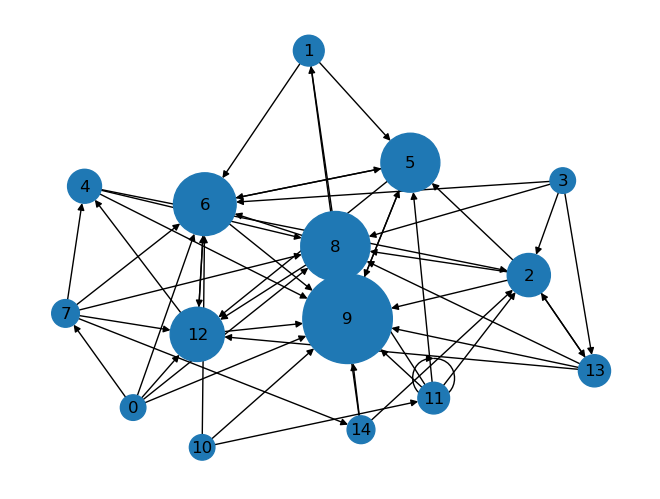

In [27]:
nx.draw_kamada_kawai(G2, with_labels=True, node_size=pr_value**3*1e5)